In [1]:
import util
import xarray 
import numpy as np
ds = util.get_dataset()
sst_ds = xarray.open_dataset("../data/sst.wkmean.1990-present.nc")
sst_ds = sst_ds.assign_coords(lon=(((sst_ds.lon + 180) % 360) - 180)) ## Use consistent longitude
train_storms,valid_storms,test_storms = util.train_validation_test(ds,seed=42)

In [2]:
import numpy as np 

def coriolis_parameter(lat):
    return 2*np.sin(np.deg2rad(lat))

def make_X_y(ds,selected_storms,timesteps=5):
    Xout = []
    yout =[]
    storms = []
    for storm in selected_storms:
        usa_pres = ds.usa_pres.loc[storm]
        usa_wind = ds.usa_wind.loc[storm]
        ## All enteries have 360 points.
        valid_coords = ~(np.isnan(usa_wind) | np.isnan(usa_pres))
        lat = ds.lat.loc[storm][valid_coords]
        lon = ds.lon.loc[storm][valid_coords]
        storm_speed = ds.storm_speed.loc[storm][valid_coords]
        storm_dir = ds.storm_dir.loc[storm][valid_coords]
        u = storm_speed*np.sin(np.deg2rad(storm_dir))
        v = storm_speed*np.cos(np.deg2rad(storm_dir))
        usa_pres = usa_pres[valid_coords]
        usa_wind = usa_wind[valid_coords]
        time = ds.time.loc[storm][valid_coords]
        cor_param = coriolis_parameter(lat)
        try:
            sst = sst_ds.sst.interp(time=time,lat=lat,lon=lon)
        except ValueError:
            continue
        if np.isnan(sst).any():
            continue

        X = np.transpose(np.array([usa_wind,usa_pres,u,v,cor_param,sst,lat,lon]))
        for i in range(0,len(usa_wind)):
            if i+timesteps+1>=len(usa_wind):
                break
            Xout.append(X[i:i+timesteps])
            yout.append(X[i+timesteps+1][:4])
            storms.append(storm)
    return np.stack(Xout),np.stack(yout),np.array(storms)

In [9]:
TIMEPOINTS = 3
x_train,y_train,storm_train = make_X_y(ds,train_storms,TIMEPOINTS)
x_valid,y_valid,storm_valid = make_X_y(ds,valid_storms,TIMEPOINTS)

### Training

In [10]:
from xgboost import XGBRegressor
xgb_rs = [XGBRegressor(n_estimators=250,eta=0.1,n_jobs=-1) for i in range(4)]
for i,xr in enumerate(xgb_rs):
    xr.fit(x_train.reshape((x_train.shape[0],-1)),y_train[:,i])



In [11]:
y_pred = np.zeros(y_valid.shape)
for i,xr in enumerate(xgb_rs):
    y_pred[:,i] = xr.predict(x_valid.reshape((x_valid.shape[0],-1)))

In [12]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_valid,y_pred,multioutput='raw_values',squared=False)

array([3.74388301, 2.84091246, 2.25729129, 2.10526105])

#### investigate t

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
for timepoints in [1,3,5,10,15,20,50]:
    print(f"--- Timepoints {timepoints} ---")
    x_train_i,y_train_i,storm_train_i = make_X_y(ds,train_storms,timepoints)
    x_valid_i,y_valid_i,storm_valid_i = make_X_y(ds,valid_storms,timepoints)

    xgb_rs = [XGBRegressor(n_estimators=250,eta=0.1,n_jobs=-1) for i in range(4)]
    y_pred_i = np.zeros(y_valid_i.shape)
    for i,xr in enumerate(xgb_rs):
        xr.fit(x_train_i.reshape((x_train_i.shape[0],-1)),y_train_i[:,i])
        y_pred_i[:,i] = xr.predict(x_valid_i.reshape((x_valid_i.shape[0],-1)))
    print(mean_squared_error(y_valid_i,y_pred_i,multioutput='raw_values',squared=False))



--- Timepoints 1 ---
[4.82880168 3.52574469 2.43094638 2.35349497]
--- Timepoints 3 ---
[3.74388301 2.84091246 2.25729129 2.10526105]
--- Timepoints 5 ---
[3.82653792 2.91273841 2.23524629 2.14408501]
--- Timepoints 10 ---
[3.91722686 3.00815484 2.28339034 2.19990955]
--- Timepoints 15 ---
[3.98680861 3.12619114 2.306797   2.24007204]
--- Timepoints 20 ---
[4.06952511 3.17437028 2.30976911 2.30572392]
--- Timepoints 50 ---
[4.35084136 3.42999387 2.65676028 2.76655626]


In [8]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
for timepoints in [1,3,5,10,15,20,50]:
    print(f"--- Timepoints {timepoints} ---")
    x_train_i,y_train_i,storm_train_i = make_X_y(ds,train_storms,timepoints)
    x_valid_i,y_valid_i,storm_valid_i = make_X_y(ds,valid_storms,timepoints)

    xgb_rs = [XGBRegressor(n_estimators=1000,eta=0.1,n_jobs=-1) for i in range(4)]
    y_pred_i = np.zeros(y_valid_i.shape)
    for i,xr in enumerate(xgb_rs):
        xr.fit(x_train_i.reshape((x_train_i.shape[0],-1)),y_train_i[:,i])
        y_pred_i[:,i] = xr.predict(x_valid_i.reshape((x_valid_i.shape[0],-1)))
    print(mean_squared_error(y_valid_i,y_pred_i,multioutput='raw_values',squared=False))

--- Timepoints 1 ---
[4.8833269  3.60411194 2.4771135  2.41299133]
--- Timepoints 3 ---
[3.75126154 2.8504399  2.27191586 2.11021398]
--- Timepoints 5 ---
[3.8345099  2.90607349 2.24513733 2.151484  ]
--- Timepoints 10 ---
[3.96078341 3.01638387 2.30049851 2.21239733]
--- Timepoints 15 ---
[4.04938519 3.13092082 2.32850217 2.25014593]
--- Timepoints 20 ---
[4.11787501 3.18864906 2.34189653 2.32376663]
--- Timepoints 50 ---
[4.41309932 3.46463113 2.68696695 2.78623923]


### Sample Profiles

In [13]:
from geopy.distance import distance
from geopy.point import Point
from datetime import timedelta
def get_predicted_latlon_from_speed(lat,lon,u,v):
    d = np.sqrt(u**2 + v**2)*3*1.852 ## convert to kilometers across 6 hours intervals
    bearing = np.rad2deg(np.arctan2(u,v))
    predicted = distance(kilometers=d).destination(Point(latitude=lat,longitude=lon),bearing)
    return predicted.latitude,predicted.longitude



def recursive_prediction(initial_x,models,length,start_time):
    y = np.zeros((length,6))
    timestep = initial_x.shape[0]
    y[:timestep] = initial_x[:,[0,1,2,3,6,7]]
    x = initial_x
    for step in range(length - timestep):
        out = [0]*4
        for i,xgbr in enumerate(models):
            out[i] = xgbr.predict(x.reshape(1,-1))[0]
        uMax,Pmin,u,v = out
        old_lat,old_lon = x[-1,-2],x[-1,-1]
        interp_lat,interp_lon = get_predicted_latlon_from_speed(old_lat,old_lon,u,v)
        cor_param= coriolis_parameter(interp_lat)
        sst = float(sst_ds.sst.interp(time=start_time+np.timedelta64((3)*(step+1),'h'),lat=interp_lat,lon=interp_lon))
        if np.isnan(sst):
            sst = x[-1][5]
        y[step+timestep] = [uMax,Pmin,u,v,interp_lat,interp_lon]

        x = np.roll(x,-1,axis=0)
        x[-1] = [uMax,Pmin,u,v,cor_param,sst,interp_lat,interp_lon]
    return y 


In [14]:
def get_storm_seeds(ds,selected_storms,timestep:int=5):
    """
    Similar but generates X, vector of storm seed and y, vector of entire storm prediction track
    """
    Xout,yout,start_times=[],[],[]

    for storm in selected_storms:
        usa_pres = ds.usa_pres.loc[storm]
        usa_wind = ds.usa_wind.loc[storm]
        ## All enteries have 360 points.
        valid_coords = ~(np.isnan(usa_wind) | np.isnan(usa_pres))
        lat = ds.lat.loc[storm][valid_coords]
        lon = ds.lon.loc[storm][valid_coords]
        storm_speed = ds.storm_speed.loc[storm][valid_coords]
        storm_dir = ds.storm_dir.loc[storm][valid_coords]
        u = storm_speed*np.sin(np.deg2rad(storm_dir))
        v = storm_speed*np.cos(np.deg2rad(storm_dir))
        usa_pres = usa_pres[valid_coords]
        usa_wind = usa_wind[valid_coords]
        time = ds.time.loc[storm][valid_coords]
        cor_param = coriolis_parameter(lat)
        try:
            sst = sst_ds.sst.interp(time=time,lat=lat,lon=lon)
        except ValueError:
            continue
        if np.isnan(sst).any():
            continue
        if timestep+1>=len(usa_wind):
            continue

        X = np.transpose(np.array([usa_wind,usa_pres,u,v,cor_param,sst,lat,lon]))
    
        Xout.append(X[:timestep])
        yout.append(X)
        start_times.append(time[timestep].values)
    return Xout,yout,np.array(start_times)

In [32]:
x_test,y_test,storm_test = make_X_y(ds,test_storms,TIMEPOINTS)

In [33]:
y_pred_test = np.zeros(y_test.shape)
for i,xr in enumerate(xgb_rs):
    y_pred_test[:,i] = xr.predict(x_test.reshape((x_test.shape[0],-1)))

In [34]:
mean_squared_error(y_test,y_pred_test,multioutput='raw_values',squared=False)

array([3.25731564, 2.42239294, 1.92818946, 1.79032441])

In [15]:
test_storm_seed,test_tracks,test_start_times = get_storm_seeds(ds,test_storms,timestep=TIMEPOINTS)

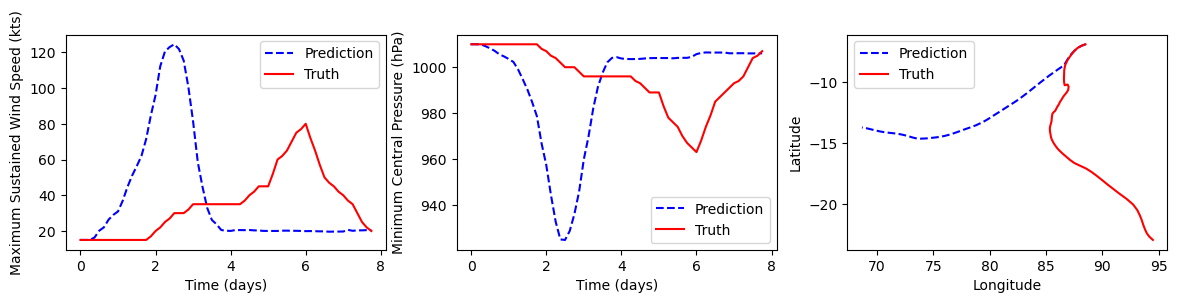

In [31]:
import matplotlib.pyplot as plt
STORM = 10
prediction_length = len(test_tracks[STORM]) 
storm_prediction = recursive_prediction(test_storm_seed[STORM],xgb_rs,prediction_length,test_start_times[STORM])
t=np.arange(0,prediction_length/8,0.125)
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(12,3))
fig.tight_layout(pad=2)
ax[0].plot(t,storm_prediction[:,0],'b--',label='Prediction')
ax[0].plot(t[:len(test_tracks[STORM])],test_tracks[STORM][:,0],'r-',label='Truth')
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Maximum Sustained Wind Speed (kts)")
ax[0].legend()
ax[1].plot(t,storm_prediction[:,1],'b--',label='Prediction')
ax[1].plot(t[:len(test_tracks[STORM])],test_tracks[STORM][:,1],'r-',label='Truth')
ax[1].set_xlabel("Time (days)")
ax[1].set_ylabel("Minimum Central Pressure (hPa)")
ax[1].legend()
ax[2].plot(storm_prediction[:,-1],storm_prediction[:,-2],'b--',label='Prediction')
ax[2].plot(test_tracks[STORM][:,-1],test_tracks[STORM][:,-2],'r-',label='Truth')
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")
ax[2].legend()
fig.savefig(f"plots/xgb_test_{STORM}.png")

### SSHS

In [46]:
max_speed_truth = np.array([max(track[:,0]) for track in val_tracks])
max_speed_pred = np.array([max(track[:,0]) for track in predictions])

In [47]:
mean_squared_error(max_speed_truth,max_speed_pred,squared=False)

38.12702919307711

In [48]:
np.sqrt(np.median((max_speed_pred - max_speed_truth)**2))

19.951654794158085